In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForImageClassification, Trainer, TrainingArguments
import wandb
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
import torch.optim as optim

import wandb

# Initialize the wandb run
wandb.init(project="efficientnet-b0")

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# Use CPU as the device
device = torch.device("cpu")
print(f"Using device: {device}")

# Define a path to your dataset
dataset_path = r'data\constellation_dataset_1'

# Load CSV labels (this will change for train, valid, and test)
def load_labels(csv_path):
    return pd.read_csv(csv_path)

# Define transformations for images
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset class
class ConstellationDataset(Dataset):
    def __init__(self, data, img_dir, transform=None):
        self.data = data
        self.img_dir = img_dir
        self.transform = transform
        # Initialize the image processor (ensure this is compatible with the model you're using)
        self.processor = AutoImageProcessor.from_pretrained("google/efficientnet-b0")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]  # First column is filename
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        
        # Extract the labels (all other columns in the CSV file)
        labels = self.data.iloc[idx, 1:].values  # Columns 1 to n are labels
        
        # Convert labels to numeric values (ensure they are floats)
        labels = np.asarray(labels, dtype=np.float32)  # Ensure they are float32
        
        # If any label value is 'nan' or 'None', replace it with 0 (or any default value)
        labels = np.nan_to_num(labels, nan=0.0)
        
        # Convert to a PyTorch tensor
        labels_tensor = torch.tensor(labels, dtype=torch.float32).to(device)
        
        # Preprocess the image using the processor (converts image to pixel_values)
        encoding = self.processor(images=image, return_tensors="pt")
        pixel_values = encoding.pixel_values.squeeze(0).to(device)
        
        return {
            'pixel_values': pixel_values,
            'labels': labels_tensor
        }

# Load the CSV files and prepare datasets
train_labels = load_labels(os.path.join(dataset_path, 'train', '_classes.csv'))
valid_labels = load_labels(os.path.join(dataset_path, 'valid', '_classes.csv'))
test_labels = load_labels(os.path.join(dataset_path, 'test', '_classes.csv'))

train_dataset = ConstellationDataset(train_labels, os.path.join(dataset_path, 'train', 'images'), transform)
valid_dataset = ConstellationDataset(valid_labels, os.path.join(dataset_path, 'valid', 'images'), transform)
test_dataset = ConstellationDataset(test_labels, os.path.join(dataset_path, 'test', 'images'), transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: arsive. Use `wandb login --relogin` to force relogin


Using device: cpu


In [2]:

# Load the model
processor = AutoImageProcessor.from_pretrained("google/efficientnet-b0")
model = AutoModelForImageClassification.from_pretrained("google/efficientnet-b0")
model.to(device)


# Modify the classifier layer for multi-label classification
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256), 
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 16),
    nn.Sigmoid()
)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)

model.classifier.apply(init_weights)

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

# Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)


In [3]:

# Define a function to compute metrics (accuracy, F1 score, and ROC-AUC)
def compute_metrics(p):
    preds, labels = p
    preds = (preds > 0.5).astype(int)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    fpr, tpr, _ = roc_curve(labels.flatten(), preds.flatten())
    roc_auc = auc(fpr, tpr)
    return {"accuracy": accuracy, "f1": f1, "roc_auc": roc_auc}

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,  # Increase the number of epochs
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    save_steps=100,
    load_best_model_at_end=True,
    fp16=False,  # No mixed precision on CPU
    learning_rate=1e-3,
    weight_decay=0.01,
    warmup_ratio=0.1,
    max_grad_norm=1.0,
    report_to="wandb"
)

# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)


c:\Users\sivap\anaconda3\envs\stellar\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [4]:

# Train the model
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


  0%|          | 0/520 [00:00<?, ?it/s]

{'loss': 0.8602, 'grad_norm': 0.4027891159057617, 'learning_rate': 0.00019230769230769233, 'epoch': 0.19}
{'loss': 0.8402, 'grad_norm': 0.32826748490333557, 'learning_rate': 0.00038461538461538467, 'epoch': 0.38}
{'loss': 0.7964, 'grad_norm': 0.278286874294281, 'learning_rate': 0.0005769230769230769, 'epoch': 0.58}
{'loss': 0.738, 'grad_norm': 0.1702919453382492, 'learning_rate': 0.0007692307692307693, 'epoch': 0.77}
{'loss': 0.7029, 'grad_norm': 0.10570020973682404, 'learning_rate': 0.0009615384615384616, 'epoch': 0.96}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.6927651166915894, 'eval_accuracy': 0.2345415778251599, 'eval_f1': 0.7004735499583912, 'eval_roc_auc': 0.7999291123793116, 'eval_runtime': 3.1162, 'eval_samples_per_second': 150.504, 'eval_steps_per_second': 4.814, 'epoch': 1.0}
{'loss': 0.6816, 'grad_norm': 0.08787744492292404, 'learning_rate': 0.0009829059829059828, 'epoch': 1.15}
{'loss': 0.6722, 'grad_norm': 0.06512584537267685, 'learning_rate': 0.0009615384615384616, 'epoch': 1.35}
{'loss': 0.6611, 'grad_norm': 0.056034885346889496, 'learning_rate': 0.0009401709401709402, 'epoch': 1.54}
{'loss': 0.6631, 'grad_norm': 0.06368554383516312, 'learning_rate': 0.0009188034188034187, 'epoch': 1.73}
{'loss': 0.6482, 'grad_norm': 0.05745115131139755, 'learning_rate': 0.0008974358974358974, 'epoch': 1.92}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.6446645259857178, 'eval_accuracy': 0.55863539445629, 'eval_f1': 0.8960006512080296, 'eval_roc_auc': 0.9166123793115826, 'eval_runtime': 2.9966, 'eval_samples_per_second': 156.51, 'eval_steps_per_second': 5.006, 'epoch': 2.0}
{'loss': 0.6548, 'grad_norm': 0.05035321041941643, 'learning_rate': 0.0008760683760683761, 'epoch': 2.12}
{'loss': 0.646, 'grad_norm': 0.054997317492961884, 'learning_rate': 0.0008547008547008547, 'epoch': 2.31}
{'loss': 0.645, 'grad_norm': 0.05305401235818863, 'learning_rate': 0.0008333333333333334, 'epoch': 2.5}
{'loss': 0.6474, 'grad_norm': 0.05746385455131531, 'learning_rate': 0.000811965811965812, 'epoch': 2.69}
{'loss': 0.644, 'grad_norm': 0.04523672163486481, 'learning_rate': 0.0007905982905982905, 'epoch': 2.88}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.6376723051071167, 'eval_accuracy': 0.6183368869936035, 'eval_f1': 0.917876540485088, 'eval_roc_auc': 0.9324732601127024, 'eval_runtime': 2.8091, 'eval_samples_per_second': 166.96, 'eval_steps_per_second': 5.34, 'epoch': 3.0}
{'loss': 0.6461, 'grad_norm': 0.032336313277482986, 'learning_rate': 0.0007692307692307693, 'epoch': 3.08}
{'loss': 0.6433, 'grad_norm': 0.04790787771344185, 'learning_rate': 0.0007478632478632479, 'epoch': 3.27}
{'loss': 0.6378, 'grad_norm': 0.04472923278808594, 'learning_rate': 0.0007264957264957265, 'epoch': 3.46}
{'loss': 0.6382, 'grad_norm': 0.04825100675225258, 'learning_rate': 0.0007051282051282052, 'epoch': 3.65}
{'loss': 0.6365, 'grad_norm': 0.05675205960869789, 'learning_rate': 0.0006837606837606838, 'epoch': 3.85}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.6399676203727722, 'eval_accuracy': 0.6119402985074627, 'eval_f1': 0.8869254956922701, 'eval_roc_auc': 0.9085931050572486, 'eval_runtime': 2.8572, 'eval_samples_per_second': 164.145, 'eval_steps_per_second': 5.25, 'epoch': 4.0}
{'loss': 0.6416, 'grad_norm': 0.03696734085679054, 'learning_rate': 0.0006623931623931623, 'epoch': 4.04}
{'loss': 0.6379, 'grad_norm': 0.047932278364896774, 'learning_rate': 0.0006410256410256411, 'epoch': 4.23}
{'loss': 0.6369, 'grad_norm': 0.049485012888908386, 'learning_rate': 0.0006196581196581197, 'epoch': 4.42}
{'loss': 0.6348, 'grad_norm': 0.04207012429833412, 'learning_rate': 0.0005982905982905983, 'epoch': 4.62}
{'loss': 0.6392, 'grad_norm': 0.03545180708169937, 'learning_rate': 0.0005769230769230769, 'epoch': 4.81}
{'loss': 0.6376, 'grad_norm': 0.09927377849817276, 'learning_rate': 0.0005555555555555556, 'epoch': 5.0}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.6342151165008545, 'eval_accuracy': 0.697228144989339, 'eval_f1': 0.9329899964186749, 'eval_roc_auc': 0.9543308746994006, 'eval_runtime': 2.8569, 'eval_samples_per_second': 164.164, 'eval_steps_per_second': 5.25, 'epoch': 5.0}
{'loss': 0.6357, 'grad_norm': 0.03855603188276291, 'learning_rate': 0.0005341880341880342, 'epoch': 5.19}
{'loss': 0.6347, 'grad_norm': 0.03702457994222641, 'learning_rate': 0.0005128205128205128, 'epoch': 5.38}
{'loss': 0.631, 'grad_norm': 0.04006663337349892, 'learning_rate': 0.0004914529914529914, 'epoch': 5.58}
{'loss': 0.6364, 'grad_norm': 0.035631921142339706, 'learning_rate': 0.0004700854700854701, 'epoch': 5.77}
{'loss': 0.6349, 'grad_norm': 0.03252111375331879, 'learning_rate': 0.0004487179487179487, 'epoch': 5.96}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.6346331238746643, 'eval_accuracy': 0.7057569296375267, 'eval_f1': 0.9387813421119401, 'eval_roc_auc': 0.9605066221600086, 'eval_runtime': 2.8142, 'eval_samples_per_second': 166.654, 'eval_steps_per_second': 5.33, 'epoch': 6.0}
{'loss': 0.6358, 'grad_norm': 0.07679057121276855, 'learning_rate': 0.00042735042735042735, 'epoch': 6.15}
{'loss': 0.6353, 'grad_norm': 0.033963192254304886, 'learning_rate': 0.000405982905982906, 'epoch': 6.35}
{'loss': 0.6335, 'grad_norm': 0.05082681402564049, 'learning_rate': 0.00038461538461538467, 'epoch': 6.54}
{'loss': 0.6293, 'grad_norm': 0.041747137904167175, 'learning_rate': 0.00036324786324786325, 'epoch': 6.73}
{'loss': 0.6337, 'grad_norm': 0.03903717175126076, 'learning_rate': 0.0003418803418803419, 'epoch': 6.92}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.6342683434486389, 'eval_accuracy': 0.7356076759061834, 'eval_f1': 0.9360943291993804, 'eval_roc_auc': 0.9552555543591401, 'eval_runtime': 2.9516, 'eval_samples_per_second': 158.899, 'eval_steps_per_second': 5.082, 'epoch': 7.0}
{'loss': 0.6343, 'grad_norm': 0.032815828919410706, 'learning_rate': 0.00032051282051282057, 'epoch': 7.12}
{'loss': 0.6329, 'grad_norm': 0.041105613112449646, 'learning_rate': 0.00029914529914529915, 'epoch': 7.31}
{'loss': 0.6293, 'grad_norm': 0.03714907914400101, 'learning_rate': 0.0002777777777777778, 'epoch': 7.5}
{'loss': 0.6301, 'grad_norm': 0.03589386120438576, 'learning_rate': 0.0002564102564102564, 'epoch': 7.69}
{'loss': 0.6325, 'grad_norm': 0.05599692091345787, 'learning_rate': 0.00023504273504273504, 'epoch': 7.88}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.6305115818977356, 'eval_accuracy': 0.7611940298507462, 'eval_f1': 0.9548292304922198, 'eval_roc_auc': 0.9711222676860127, 'eval_runtime': 3.0062, 'eval_samples_per_second': 156.009, 'eval_steps_per_second': 4.99, 'epoch': 8.0}
{'loss': 0.6327, 'grad_norm': 0.02362099476158619, 'learning_rate': 0.00021367521367521368, 'epoch': 8.08}
{'loss': 0.6322, 'grad_norm': 0.03486969321966171, 'learning_rate': 0.00019230769230769233, 'epoch': 8.27}
{'loss': 0.6281, 'grad_norm': 0.025667568668723106, 'learning_rate': 0.00017094017094017094, 'epoch': 8.46}
{'loss': 0.634, 'grad_norm': 0.04850420728325844, 'learning_rate': 0.00014957264957264957, 'epoch': 8.65}
{'loss': 0.6344, 'grad_norm': 0.03638933598995209, 'learning_rate': 0.0001282051282051282, 'epoch': 8.85}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.6266661882400513, 'eval_accuracy': 0.837953091684435, 'eval_f1': 0.9712314433481823, 'eval_roc_auc': 0.9792667169161193, 'eval_runtime': 3.5216, 'eval_samples_per_second': 133.176, 'eval_steps_per_second': 4.259, 'epoch': 9.0}
{'loss': 0.6326, 'grad_norm': 0.03059285879135132, 'learning_rate': 0.00010683760683760684, 'epoch': 9.04}
{'loss': 0.6336, 'grad_norm': 0.049443043768405914, 'learning_rate': 8.547008547008547e-05, 'epoch': 9.23}
{'loss': 0.628, 'grad_norm': 0.03177700564265251, 'learning_rate': 6.41025641025641e-05, 'epoch': 9.42}
{'loss': 0.6312, 'grad_norm': 0.020306626334786415, 'learning_rate': 4.2735042735042735e-05, 'epoch': 9.62}
{'loss': 0.6309, 'grad_norm': 0.028399361297488213, 'learning_rate': 2.1367521367521368e-05, 'epoch': 9.81}
{'loss': 0.6262, 'grad_norm': 0.15481750667095184, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.6275761127471924, 'eval_accuracy': 0.8208955223880597, 'eval_f1': 0.9660634190523598, 'eval_roc_auc': 0.9749636588780016, 'eval_runtime': 3.4908, 'eval_samples_per_second': 134.352, 'eval_steps_per_second': 4.297, 'epoch': 10.0}
{'train_runtime': 182.4844, 'train_samples_per_second': 89.925, 'train_steps_per_second': 2.85, 'train_loss': 0.6533557873505812, 'epoch': 10.0}


TrainOutput(global_step=520, training_loss=0.6533557873505812, metrics={'train_runtime': 182.4844, 'train_samples_per_second': 89.925, 'train_steps_per_second': 2.85, 'total_flos': 7.114660613480448e+16, 'train_loss': 0.6533557873505812, 'epoch': 10.0})

In [ ]:

# Evaluate the model
eval_results = trainer.evaluate()


  0%|          | 0/15 [00:00<?, ?it/s]

In [9]:
eval_results

{'eval_loss': 0.6266661882400513,
 'eval_accuracy': 0.837953091684435,
 'eval_f1': 0.9712314433481823,
 'eval_roc_auc': 0.9792667169161193,
 'eval_runtime': 2.9087,
 'eval_samples_per_second': 161.24,
 'eval_steps_per_second': 5.157,
 'epoch': 10.0}

In [6]:

# Save the model
model.save_pretrained("efficientnet_constellation_classification_cpu")

In [13]:
trainer.state.log_history

[{'loss': 0.8602,
  'grad_norm': 0.4027891159057617,
  'learning_rate': 0.00019230769230769233,
  'epoch': 0.19230769230769232,
  'step': 10},
 {'loss': 0.8402,
  'grad_norm': 0.32826748490333557,
  'learning_rate': 0.00038461538461538467,
  'epoch': 0.38461538461538464,
  'step': 20},
 {'loss': 0.7964,
  'grad_norm': 0.278286874294281,
  'learning_rate': 0.0005769230769230769,
  'epoch': 0.5769230769230769,
  'step': 30},
 {'loss': 0.738,
  'grad_norm': 0.1702919453382492,
  'learning_rate': 0.0007692307692307693,
  'epoch': 0.7692307692307693,
  'step': 40},
 {'loss': 0.7029,
  'grad_norm': 0.10570020973682404,
  'learning_rate': 0.0009615384615384616,
  'epoch': 0.9615384615384616,
  'step': 50},
 {'eval_loss': 0.6927651166915894,
  'eval_accuracy': 0.2345415778251599,
  'eval_f1': 0.7004735499583912,
  'eval_roc_auc': 0.7999291123793116,
  'eval_runtime': 3.1162,
  'eval_samples_per_second': 150.504,
  'eval_steps_per_second': 4.814,
  'epoch': 1.0,
  'step': 52},
 {'loss': 0.6816,

**Evaluation Metrics:**
Accuracy: 0.8380
F1 Score (Weighted): 0.9712
ROC-AUC: 0.9793


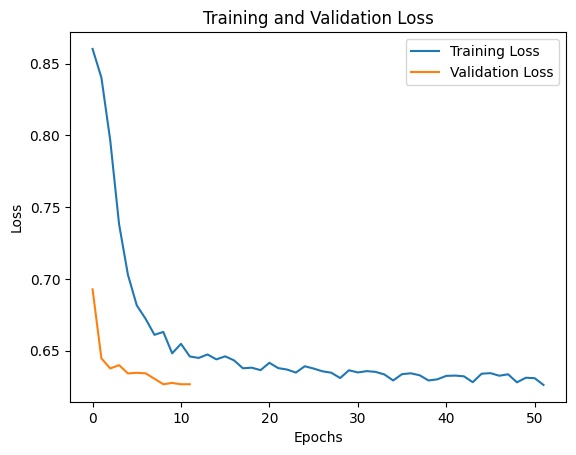

  0%|          | 0/15 [00:00<?, ?it/s]

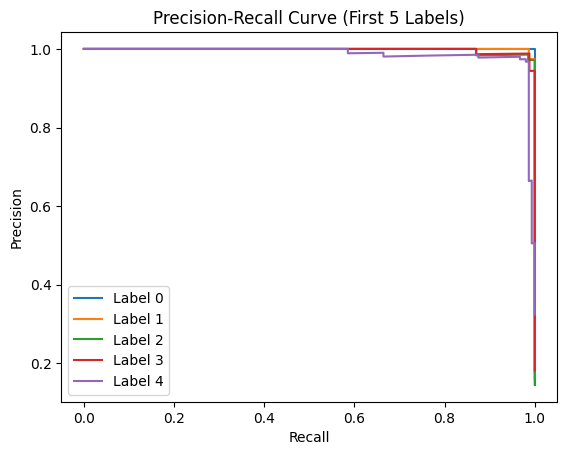

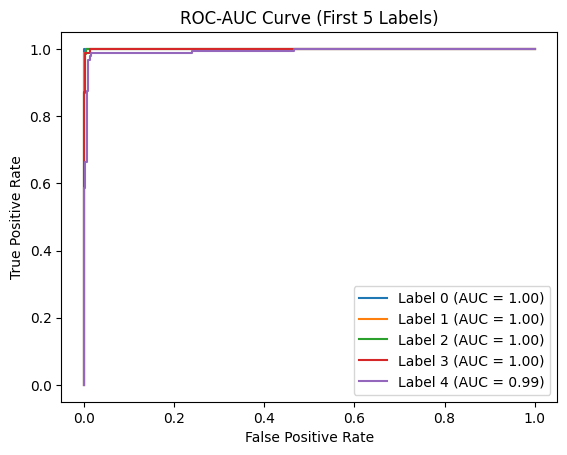

In [14]:
# **Metrics Report**
print("**Evaluation Metrics:**")
print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"F1 Score (Weighted): {eval_results['eval_f1']:.4f}")
print(f"ROC-AUC: {eval_results['eval_roc_auc']:.4f}")

# **Training and Validation Loss Plot**
import matplotlib.pyplot as plt

train_loss = [loss['loss'] for loss in trainer.state.log_history if 'loss' in loss]
valid_loss = [loss['eval_loss'] for loss in trainer.state.log_history if 'eval_loss' in loss]

plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# **Precision-Recall Curve for Each Label (first 5 labels)**
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get predictions on the validation set
preds = trainer.predict(valid_dataset).predictions
labels = np.asarray([ex['labels'] for ex in valid_dataset])

# Plot PR curve for each label (first 5 labels)
for i in range(5):
    precision, recall, _ = precision_recall_curve(labels[:, i], preds[:, i])
    plt.plot(recall, precision, label=f'Label {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve (First 5 Labels)')
plt.show()

# **ROC-AUC Curve for Each Label (first 5 labels)**
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Plot ROC-AUC curve for each label (first 5 labels)
for i in range(5):
    fpr, tpr, _ = roc_curve(labels[:, i], preds[:, i])
    roc_auc = roc_auc_score(labels[:, i], preds[:, i])
    plt.plot(fpr, tpr, label=f'Label {i} (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC-AUC Curve (First 5 Labels)')
plt.show()